In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import geopy
import geopy.distance
from sklearn.cluster import KMeans
import folium
from sklearn import preprocessing

In [2]:
data = pd.read_csv('ALL_SPB_STOPS.csv', sep=';', encoding='cp1251')
data

,ID_STOP,STOP_NAME,LATITUDE,LONGITUDE
0,100101,Пр.Ветеранов-1,59.841604,30.253984
1,100102,Пр.Ветеранов-2,59.842042,30.250084
2,100103,Ленинский пр.-1,59.851683,30.268385
3,100104,Ленинский пр.-2,59.849710,30.268348
4,100105,Автово,59.867292,30.261133
...,...,...,...,...
7149,4997,ЗАВОД ИМ. КАЛИНИНА [тест] <,59.950695,30.266132
7150,4998,МАЛЫЙ ПР. В.О. ПО 9 ЛИНИИ [тест] <,59.945698,30.271969
7151,5003,АДМИРАЛТЕЙСКИЙ ПР. [тест] <,59.936026,30.309259
7152,7069,ПР. ЛУНАЧАРСКОГО(тест),60.031439,30.392572


In [3]:
parnas_coord = (round(float(data[data['STOP_NAME'] == "Парнас"].LATITUDE), 6), (round(float(data[data['STOP_NAME'] == "Парнас"].LONGITUDE), 6)))
parnas_coord

(60.067113, 30.33416)

# Пример 1. Пока что не знаем, сколько будет кластеров


In [4]:
near_parnas = pd.DataFrame({'LATITUDE':[], 'LONGITUDE':[]})
near_parnas

,LATITUDE,LONGITUDE


In [5]:
for index, row in data.iterrows():
    if row.STOP_NAME != 'Парнас':
        area = (row.LATITUDE, row.LONGITUDE)
        if geopy.distance.geodesic(parnas_coord, area).m <= 1000 :
            near_parnas.loc[len(near_parnas)] = [row.LATITUDE, row.LONGITUDE]

In [6]:
near_parnas

,LATITUDE,LONGITUDE
0,60.071334,30.350000
1,60.062800,30.318912
2,60.064712,30.317291
3,60.065997,30.345356
4,60.062762,30.318865
5,60.067984,30.334772
6,60.067200,30.336599
7,60.070881,30.349028
8,60.065537,30.344164
9,60.070111,30.327871


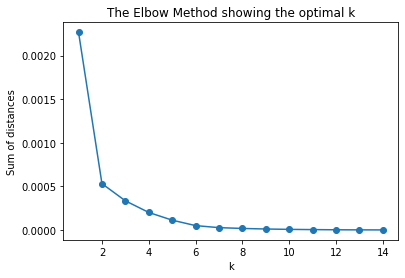

In [7]:
K = range(1, 15)
models = [KMeans(n_clusters=k, random_state=42).fit(near_parnas) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [8]:
# инициализация модели
model = KMeans(n_clusters=7, random_state=42)

In [9]:
# подгонка модели по данным из df
# фиксирует центры кластеров
model.fit(near_parnas)

KMeans(n_clusters=7, random_state=42)

In [10]:
# Результат кластеризации на данных df
model.labels_

array([0, 1, 1, 5, 1, 2, 2, 0, 5, 4, 4, 6, 1, 3, 3, 3, 5])

In [11]:
near_parnas = near_parnas.merge(data[['LATITUDE', 'STOP_NAME']], how='left')

In [12]:
near_parnas['cluster'] = model.labels_
near_parnas

,LATITUDE,LONGITUDE,STOP_NAME,cluster
0,60.071334,30.350000,"4-Й ВЕРХНИЙ ПЕРЕУЛОК [113, 113]",0
1,60.062800,30.318912,Улица Композиторов (21),1
2,60.064712,30.317291,конечная станция «ул.Жени Егоровой» Т (58),1
3,60.065997,30.345356,"ПР. ЭНГЕЛЬСА,УГ. 3-ГО ВЕРХНЕГО ПЕРЕУЛКА [113]",5
4,60.062762,30.318865,"УЛ. КОМПОЗИТОРОВ УГ. УЛ. ПРОКОФЬЕВА [123, 143,...",1
5,60.067984,30.334772,"СТ. МЕТРО ""ПАРНАС""",2
6,60.067200,30.336599,"СТ. МЕТРО ""ПАРНАС""",2
7,60.070881,30.349028,"4-Й ВЕРХНИЙ ПЕРЕУЛОК [113, 113]<",0
8,60.065537,30.344164,УЛ. МИХАИЛА ДУДИНА УГ. ПР. ЭНГЕЛЬСА,5
9,60.070111,30.327871,"УЛ. МИХАИЛА ДУДИНА, 25",4


In [18]:
map = folium.Map(location=[parnas_coord[0], parnas_coord[1]], zoom_start = 15)
      
for index, row in near_parnas.iterrows():
    if row.cluster == 0 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'blue')).add_to(map)
    if row.cluster == 1 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'red')).add_to(map)    
    if row.cluster == 2 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'green')).add_to(map)
    if row.cluster == 3 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'black')).add_to(map)    
    if row.cluster == 4 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'white')).add_to(map)
    if row.cluster == 5 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'pink')).add_to(map)    
    if row.cluster == 6 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'orange')).add_to(map)

map.save("map_clusters7.html")

# Пример 2. Для 3 кластеров

In [17]:
# инициализация модели
model = KMeans(n_clusters=3, random_state=42)

In [19]:
near_parnas_cluster3 = pd.DataFrame({'LATITUDE':[], 'LONGITUDE':[]})
near_parnas_cluster3

,LATITUDE,LONGITUDE


In [20]:
for index, row in data.iterrows():
    if row.STOP_NAME != 'Парнас':
        area = (row.LATITUDE, row.LONGITUDE)
        if geopy.distance.geodesic(parnas_coord, area).m <= 1000 :
            near_parnas_cluster3.loc[len(near_parnas_cluster3)] = [row.LATITUDE, row.LONGITUDE]

In [21]:
near_parnas_cluster3

,LATITUDE,LONGITUDE
0,60.071334,30.350000
1,60.062800,30.318912
2,60.064712,30.317291
3,60.065997,30.345356
4,60.062762,30.318865
5,60.067984,30.334772
6,60.067200,30.336599
7,60.070881,30.349028
8,60.065537,30.344164
9,60.070111,30.327871


In [22]:
# подгонка модели по данным из df
# фиксирует центры кластеров
model.fit(near_parnas_cluster3)

KMeans(n_clusters=3, random_state=42)

In [23]:
# Результат кластеризации на данных df
model.labels_

array([0, 1, 1, 0, 1, 2, 2, 0, 0, 2, 2, 2, 1, 1, 1, 1, 0])

In [24]:
near_parnas = near_parnas.merge(data[['LATITUDE', 'STOP_NAME']], how='left')
near_parnas['cluster'] = model.labels_
near_parnas

,LATITUDE,LONGITUDE,STOP_NAME,cluster
0,60.071334,30.350000,"4-Й ВЕРХНИЙ ПЕРЕУЛОК [113, 113]",0
1,60.062800,30.318912,Улица Композиторов (21),1
2,60.064712,30.317291,конечная станция «ул.Жени Егоровой» Т (58),1
3,60.065997,30.345356,"ПР. ЭНГЕЛЬСА,УГ. 3-ГО ВЕРХНЕГО ПЕРЕУЛКА [113]",0
4,60.062762,30.318865,"УЛ. КОМПОЗИТОРОВ УГ. УЛ. ПРОКОФЬЕВА [123, 143,...",1
5,60.067984,30.334772,"СТ. МЕТРО ""ПАРНАС""",2
6,60.067200,30.336599,"СТ. МЕТРО ""ПАРНАС""",2
7,60.070881,30.349028,"4-Й ВЕРХНИЙ ПЕРЕУЛОК [113, 113]<",0
8,60.065537,30.344164,УЛ. МИХАИЛА ДУДИНА УГ. ПР. ЭНГЕЛЬСА,0
9,60.070111,30.327871,"УЛ. МИХАИЛА ДУДИНА, 25",2


In [27]:
map = folium.Map(location=[parnas_coord[0], parnas_coord[1]], zoom_start = 15)
      
for index, row in near_parnas.iterrows():
    if row.cluster == 0 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'blue')).add_to(map)
    if row.cluster == 1 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'red')).add_to(map)
    if row.cluster == 2 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'black')).add_to(map)
map.save("map_clusters3.html")

# Пример 3. Стандартизируем данные

In [39]:
near_parnas = pd.DataFrame({'LATITUDE':[], 'LONGITUDE':[]})
near_parnas

,LATITUDE,LONGITUDE


In [40]:
for index, row in data.iterrows():
    if row.STOP_NAME != 'Парнас':
        area = (row.LATITUDE, row.LONGITUDE)
        if geopy.distance.geodesic(parnas_coord, area).m <= 1000 :
            near_parnas.loc[len(near_parnas)] = [row.LATITUDE, row.LONGITUDE]

In [41]:
near_parnas

,LATITUDE,LONGITUDE
0,60.071334,30.350000
1,60.062800,30.318912
2,60.064712,30.317291
3,60.065997,30.345356
4,60.062762,30.318865
5,60.067984,30.334772
6,60.067200,30.336599
7,60.070881,30.349028
8,60.065537,30.344164
9,60.070111,30.327871


In [44]:
# Стандартизируем данные
norm = preprocessing.StandardScaler()
norm.fit(near_parnas)
X = norm.transform(near_parnas)

In [47]:
pd.DataFrame(X)

,0,1
0,1.300026,1.623694
1,-0.859660,-1.240948
2,-0.375752,-1.390336
3,-0.050575,1.195729
4,-0.869149,-1.245344
5,0.452260,0.220459
6,0.253890,0.388829
7,1.185328,1.534054
8,-0.167016,1.085881
9,0.990424,-0.415426


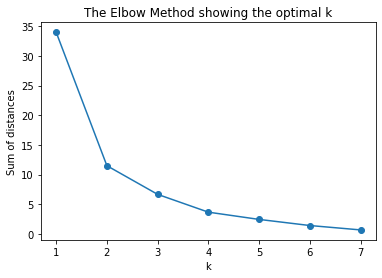

In [48]:
K = range(1, 8)
models = [KMeans(n_clusters=k, random_state=42).fit(X) for k in K]
dist = [model.inertia_ for model in models]

# Plot the elbow
plt.plot(K, dist, marker='o')
plt.xlabel('k')
plt.ylabel('Sum of distances')
plt.title('The Elbow Method showing the optimal k')
plt.show()

### Пусть кластеров будет 3

In [49]:
# инициализация модели
model = KMeans(n_clusters=3, random_state=42)

In [81]:
# подгонка модели по данным из X
# фиксирует центры кластеров
model.fit(X)

KMeans(n_clusters=3, random_state=42)

In [82]:
model.labels_

array([2, 1, 1, 2, 1, 0, 2, 2, 2, 0, 0, 0, 1, 1, 1, 1, 2])

In [83]:
merge_first = pd.DataFrame(X).reset_index().merge(near_parnas.reset_index()[['index', 'LATITUDE', 'LONGITUDE']], how='left')
merge_first

,index,0,1,LATITUDE,LONGITUDE
0,0,1.300026,1.623694,60.071334,30.350000
1,1,-0.859660,-1.240948,60.062800,30.318912
2,2,-0.375752,-1.390336,60.064712,30.317291
3,3,-0.050575,1.195729,60.065997,30.345356
4,4,-0.869149,-1.245344,60.062762,30.318865
5,5,0.452260,0.220459,60.067984,30.334772
6,6,0.253890,0.388829,60.067200,30.336599
7,7,1.185328,1.534054,60.070881,30.349028
8,8,-0.167016,1.085881,60.065537,30.344164
9,9,0.990424,-0.415426,60.070111,30.327871


In [84]:
merge_first['cluster'] = model.labels_
merge_first

,index,0,1,LATITUDE,LONGITUDE,cluster
0,0,1.300026,1.623694,60.071334,30.350000,2
1,1,-0.859660,-1.240948,60.062800,30.318912,1
2,2,-0.375752,-1.390336,60.064712,30.317291,1
3,3,-0.050575,1.195729,60.065997,30.345356,2
4,4,-0.869149,-1.245344,60.062762,30.318865,1
5,5,0.452260,0.220459,60.067984,30.334772,0
6,6,0.253890,0.388829,60.067200,30.336599,2
7,7,1.185328,1.534054,60.070881,30.349028,2
8,8,-0.167016,1.085881,60.065537,30.344164,2
9,9,0.990424,-0.415426,60.070111,30.327871,0


In [85]:
map = folium.Map(location=[parnas_coord[0], parnas_coord[1]], zoom_start = 15)
      
for index, row in merge_first.iterrows():
    if row.cluster == 0 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'blue')).add_to(map)
    if row.cluster == 1 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'red')).add_to(map)
    if row.cluster == 2 :
        folium.Marker(location=[row.LATITUDE, row.LONGITUDE], icon=folium.Icon(color = 'black')).add_to(map)
map.save("map_stand_clusters3.html")

# Видим, что в результате стандартизации на одинаковом количестве кластеров результат изменился